In [88]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import decimal
from scipy.stats import norm

Dans ce notebook, nous évaluerons l'évolution de l'imapct I(T) en fonction du nombre de pas   

In [89]:
# Nous ne fixons plus le nombre de pas P

def W_1(n,P):
    W_1 = np.random.randn(n,P)
    W_1[:, 0]= 0
    return W_1

def gen_X(X_0, W,P, delta, n =5, sigma = 8, lbda = 20):
    A = np.full((n,P),0.0)
    A[:,0] = X_0
    for p in range(1,P):
        A[:,p] =A[:,p-1]*np.exp(-lbda*delta) + X_0*(1- np.exp(-lbda*delta))+np.sqrt(delta)*sigma *W[:,p]
    return A

def gen_X_particulier(X_0,N=1, sigma_2 = 1.689):
    return X_0+np.sqrt(sigma_2)*np.random.normal(size = (N,n))

def insolvance_1(E,v, C, R = 0.05):
    assert len(v) == len(C)
    assert E.shape[0] == len(v) and E.shape[1] == len(v)
    used_up = np.full(len(v),False)
    l=-1
    while True:
        used_up+= v<C
        v = (v - (1-R)*np.sum(E*(used_up), axis = 1))*(v>=C)
        if (l == np.sum(used_up)):
            break
        l = np.sum(used_up)
    return used_up


def I(X, F, E, R = 0.05):
    return np.sum((X + (1-R)*np.sum(E[~F], axis = 0))*(F))

In [90]:
#paramètres du modèles 

N = 100000 
sigma = 8
lbda = 20 
n = 5 


R = 0.05
E = np.array([[0,3,0,0,6],
              [3,0,0,0,0],
              [3,3,0,0,0],
              [2,2,2,0,2],
              [0,2,3,3,0]])

mu = 15. ## commune
c = 10 ## commune
X_0 = np.full(n,mu)
C = np.full(n,c)

Première approche : simuler des trajectoires en entier puis estimer l'impact et les probabilités des défaillances associées

In [100]:
#On génère plusieurs trajectoires qui dépendes des pas P

P=200*np.arange(1,25)
P=P.astype(int)
delta = 1 / P
mu = 15
n = 5
num_trials = 10000
X_0=np.full(n*num_trials, mu)
list = [gen_X (X_0, W_1(num_trials*n,p), p, 1/p, n=num_trials*n) for p in P]



Text(0, 0.5, "Probabilité d' au moins une défaillance")

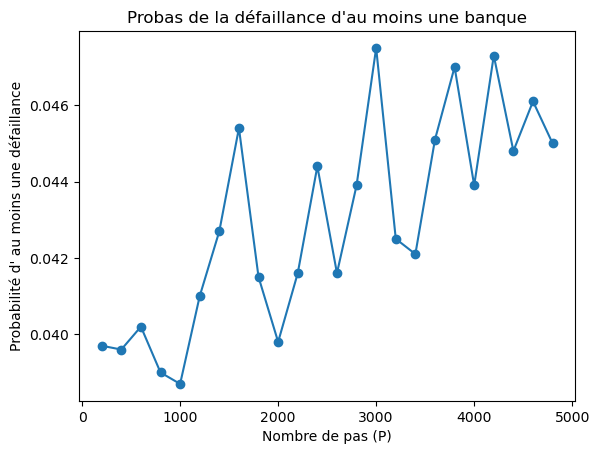

In [101]:

liste_de_matrices = [[A[ i*5:(i+1)*5] for i in range(num_trials)] for A in list ]
def proba_insolvence(i) :
    

    c = 10
    p=P[i]             # nombre de pas
    X_0 = np.array([15] * 5) 
    W = np.random.randn(5, p) 

    T_c = np.array([np.where(np.any(trial < c, axis=0))[0][0] if np.any(np.any(trial < c, axis=0)) else p for trial in liste_de_matrices[i]])

    non_atteint = len(T_c[T_c == p]) / len(T_c)
    return [1 - non_atteint, T_c]

probas = [ ] # probas d'insolvences en fonction des pas
T_c = [ ]
for i in range (len(P)):
    resultats=proba_insolvence(i)
    T_c.append(resultats[1])
    probas.append(resultats[0])
 
 
plt.plot(P, probas, 'o-')
plt.title('Probas de la défaillance d\'au moins une banque')
plt.xlabel('Nombre de pas (P)')
plt.ylabel('Probabilité d\' au moins une défaillance')
        
    
    

In [102]:
liste_de_matrices
listes_impactées = [np.array(liste_de_matrices[i])[T_c[i]<365] for i in range(len(liste_de_matrices))]
indices=[np.where(T_c[i]<365)[0] for i in range(len(T_c))]

In [104]:

def impact_calculate(i, indice):   # i réfère à l'indice dans P, indice l'indice de l'une des matrices ayant pour paramètres p
    matrix = np.copy(liste_de_matrices[i][indice])
    debut = T_c[i][indice]
    impactées = []  # banques insolvables
    impact = 0.0 
    total = 0.0

    for step in range(debut, P[i]):
        new_impactées_bool = insolvance_1(E, matrix[:, step], C)
        new_impactées = np.where(new_impactées_bool == True)[0]
        
        for j in new_impactées:
            if j in impactées:
                continue
            E[:,j]=0
            E[j,:]=0
            impactées.append(j)
            total += matrix[j, step]
            # Calcul de l'impact en s'assurant que c'est un flottant
            impact += matrix[j, step] + (1 - R) * np.sum(E[k, j] for k in range(n) if (k not in impactées))
            
            # Ajustement de la matrice
            matrice_tile = np.tile(E[:, j].reshape(-1, 1), (1, matrix.shape[1]))
            matrix = matrix - (1 - R) * matrice_tile
        
    return [impact, 1 * (len(impactées) == 5), total]

# Initialisation des variables
total_impact = np.zeros(len(P))
proba_def_total = np.zeros(len(P))



# Calcul des impacts
for i in range(len(P)):
    
    for indice in indices[i]:
        resultats = impact_calculate(i, indice)
        total_impact[i] += resultats[0]
        proba_def_total[i] += resultats[1]
    print(f"Calcul de l'imapct moyen et la probabilité de défaillance pour P[{i}] = {P[i]}")
 

# Affichage des résultats
print("Probas de la défaillance de tout le système :", proba_def_total / num_trials)
print("Impacts totals :", total_impact / num_trials)

       


/tmp/ipykernel_2505786/2941270333.py:20: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  impact += matrix[j, step] + (1 - R) * np.sum(E[k, j] for k in range(n) if (k not in impactées))


Calcul de l'imapct moyen et la probabilité de défaillance pour P[0] = 200
Calcul de l'imapct moyen et la probabilité de défaillance pour P[1] = 400
Calcul de l'imapct moyen et la probabilité de défaillance pour P[2] = 600
Calcul de l'imapct moyen et la probabilité de défaillance pour P[3] = 800
Calcul de l'imapct moyen et la probabilité de défaillance pour P[4] = 1000
Calcul de l'imapct moyen et la probabilité de défaillance pour P[5] = 1200
Calcul de l'imapct moyen et la probabilité de défaillance pour P[6] = 1400
Calcul de l'imapct moyen et la probabilité de défaillance pour P[7] = 1600
Calcul de l'imapct moyen et la probabilité de défaillance pour P[8] = 1800
Calcul de l'imapct moyen et la probabilité de défaillance pour P[9] = 2000
Calcul de l'imapct moyen et la probabilité de défaillance pour P[10] = 2200
Calcul de l'imapct moyen et la probabilité de défaillance pour P[11] = 2400
Calcul de l'imapct moyen et la probabilité de défaillance pour P[12] = 2600
Calcul de l'imapct moyen e

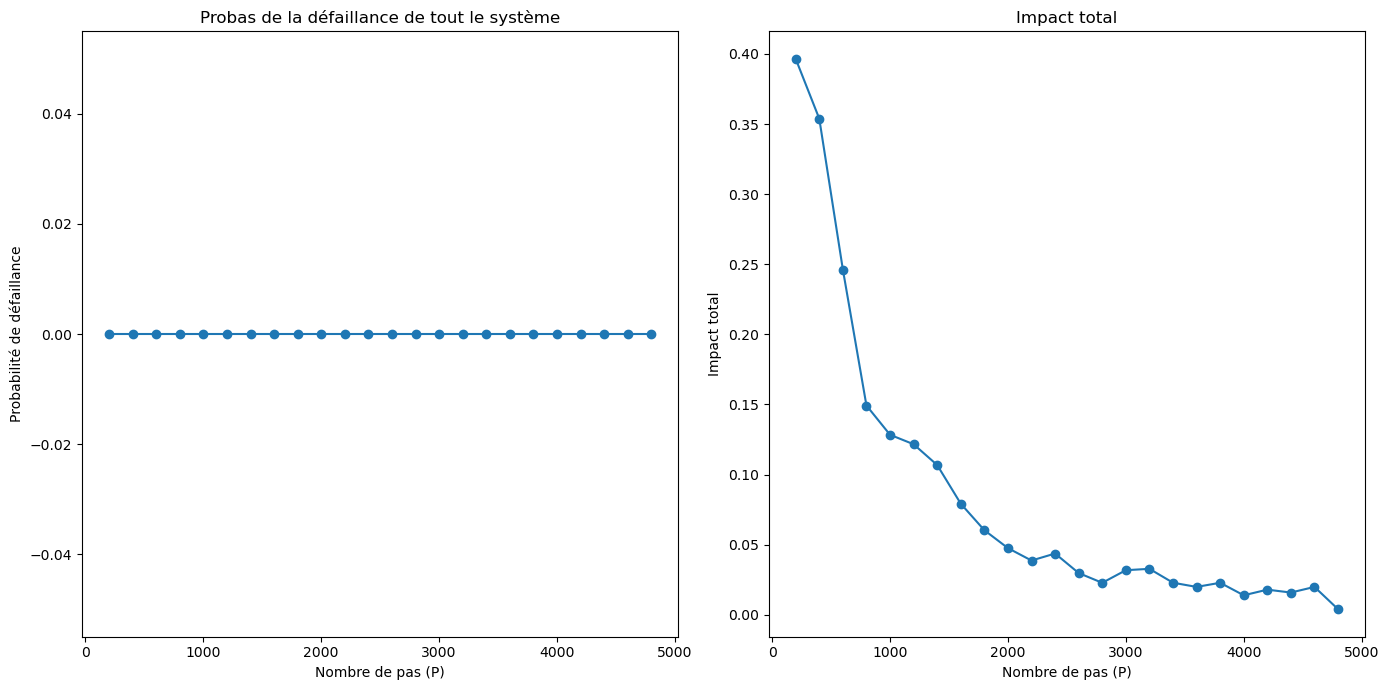

In [105]:

plt.figure(figsize=(14, 7))


plt.subplot(1, 2, 1)
plt.plot(P, proba_def_total / num_trials, 'o-')
plt.title('Probas de la défaillance de tout le système')
plt.xlabel('Nombre de pas (P)')
plt.ylabel('Probabilité de défaillance')


plt.subplot(1, 2, 2)
plt.plot(P, total_impact / num_trials, 'o-')
plt.title('Impact total')
plt.xlabel('Nombre de pas (P)')
plt.ylabel('Impact total')

plt.tight_layout()
plt.show()

Deuxième approche : Nous calculons les impacts et les probabilités de défaillance au fur et à mesure de la simulation des trajectoires. Dès qu'une banque atteint la défaillance, nous ne suivons plus l'évolution de son capital et nous ignorons son influence sur le reste du système


In [97]:
P = 200 * np.arange(1,25)
W_for_all = W_1(n, P[len(P)-1])

def calculate_impact_2(p, delta):
    capital = np.full(n, mu)
    E_n = np.copy(E)
    C_n = np.copy(C)
    W = W_1(n, p)
    impact = 0.0
    for i in range(p):
        capital = capital * np.exp(-lbda * delta) + mu * (1 - np.exp(-lbda * delta)) + np.sqrt(delta) * sigma * W[:, i]
        A = insolvance_1(E_n, capital, C_n)
        
        # Calcul de l'impact à l'instant i
        if (np.sum(A) > 0) : 
            impact += I(capital, A, E_n)
            new_impactees = np.where(A == True)[0]
            if len(new_impactees) > 0:
                E_n = np.delete(E_n, new_impactees, axis=0)
                E_n = np.delete(E_n, new_impactees, axis=1)
                W = np.delete(W, new_impactees, axis=0)
                C_n = np.delete(C_n, new_impactees)
                capital = np.delete(capital, new_impactees)
                
    
    return [impact, len(E) - len(E_n)]

In [98]:



total_impact = np.zeros(len(P))
proba_def_total = np.zeros(len(P))
num_simulations = 1000
# Calculons les impacts et des défaillances
for i in range(len(P)):
    resultats = np.array([calculate_impact_2(P[i], 1/P[i]) for _ in range(num_simulations)])
    impacts = np.mean(resultats[:, 0])
    total_impact[i] = impacts
    defaillances = resultats[:, 1]
    proba_def_total[i] = np.mean(defaillances==5)
    print(f"Calcul pour P[{i}] = {P[i]}, Impact moyen = {impacts}, proba de défaillance totale = {proba_def_total[i]}")

    

Calcul pour P[0] = 200, Impact moyen = 0.35260503513196917, proba de défaillance totale = 0.0
Calcul pour P[1] = 400, Impact moyen = 0.3734725758071305, proba de défaillance totale = 0.0
Calcul pour P[2] = 600, Impact moyen = 0.4130470336523001, proba de défaillance totale = 0.0
Calcul pour P[3] = 800, Impact moyen = 0.30509375188346866, proba de défaillance totale = 0.0
Calcul pour P[4] = 1000, Impact moyen = 0.33495450228452467, proba de défaillance totale = 0.0
Calcul pour P[5] = 1200, Impact moyen = 0.3363613220748188, proba de défaillance totale = 0.0
Calcul pour P[6] = 1400, Impact moyen = 0.4357434726913762, proba de défaillance totale = 0.0
Calcul pour P[7] = 1600, Impact moyen = 0.38614526690908235, proba de défaillance totale = 0.0
Calcul pour P[8] = 1800, Impact moyen = 0.523766539703563, proba de défaillance totale = 0.0
Calcul pour P[9] = 2000, Impact moyen = 0.40668928904759066, proba de défaillance totale = 0.0
Calcul pour P[10] = 2200, Impact moyen = 0.3858051037813697,

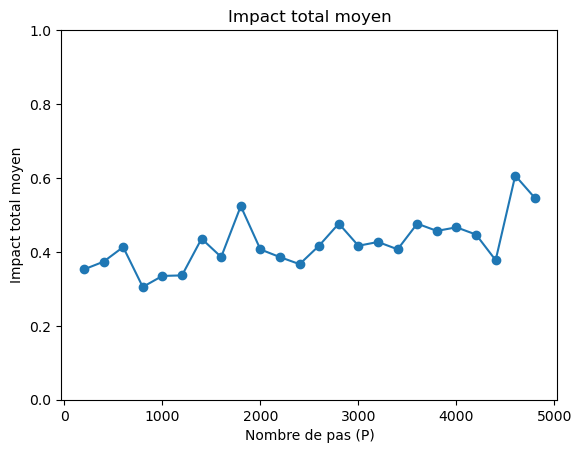

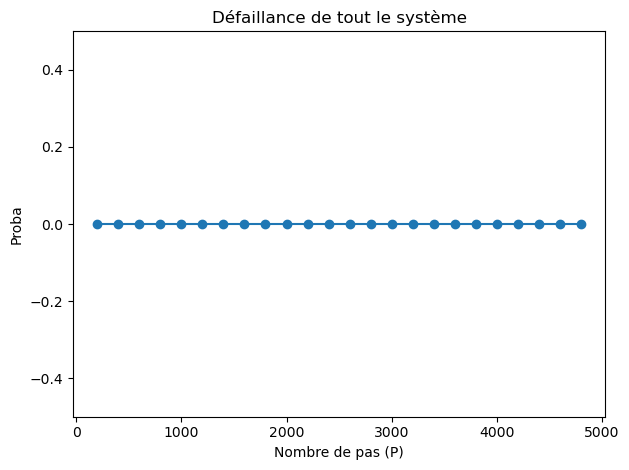

In [99]:


# Tracé de l'impact total moyen en fonction de P
plt.plot(P, total_impact, 'o-')
plt.title('Impact total moyen')
plt.xlabel('Nombre de pas (P)')
plt.ylabel('Impact total moyen')
plt.ylim(0, 1)
plt.show()

# Tracé du nombre de défaillances moyen en fonction de P
plt.plot(P, proba_def_total, 'o-')
plt.title('Défaillance de tout le système')
plt.xlabel('Nombre de pas (P)')
plt.ylabel('Proba')
plt.ylim(-0.5, 0.5)

plt.tight_layout()
plt.show()


Nous remarquons que la proba de défaillance de tout le système est estimé à 0 pour tout les pas choisis, cela est du au fait que les nombre d'échantillons pris pour chaque estimation est très réduit(1000 ou 1000 alors que la proba de défaillance totale d'après Monté Carlo naif appliqué pour des impacts statiques est de l'ordre de grandeur de 10^(-5) )

Pensons à faire de l'échantillonnage par importance:
Cette tâche n'est pas si facile étant donnée que l'échantillonnage se fera sur toute une trajectoire et non pas seulement sur la colonne finale 

Nous